# Model SEIRD

Uno de los modelos más sencillos para la evolución de una epidemia es el modelo SIR, propuesto
en 1927 por W. O. Kermack & A. G. McKendrick que se utiliza para simular enfermedades en las
que una persona infectada, una vez recuperada (o muerta) no se puede volver a infectar.
Considere una población con un número constante de personas donde cada una puede estar
susceptible, infectada (casos activos) o retirada. Sean s, i, r las fracciones de la población que están
susceptibles, infectadas o retiradas, respectivamente (𝑠 + 𝑖 + 𝑟 = 1). Asumamos que, a cada
momento, la cantidad de susceptibles que se infecta por unidad de tiempo es proporcional a la
cantidad e susceptibles multiplicada por la cantidad de infectados, 𝛽𝑠𝑖, donde 𝛽 es una constante
que nos dice qué tan contagiosa es la enfermedad. Por el contrario, la cantidad de infectados que
dejan de serlo por unidad de tiempo es solamente proporcional al número de infectados, 𝛾𝑖,
donde 1/𝛾 da el tiempo característico de recuperación. Las ecuaciones diferenciales acopladas
que rigen el comportamiento son, por lo tanto:
$$
\begin{align*}
\frac{dS}{dt} & = -\gamma S I \\
\frac{dI}{dt} & = \gamma S I - \gamma I \\
\frac{dR}{dt} & = \gamma I \\
\end{align*}
$$

donde $ \gamma $ es la tasa de contagio y $\beta$ es la tasa de recuperación. A partir de estas ecuaciones, podemos escribir un programa que utilice el método de Runge-Kutta de 4º orden para simular la evolución temporal de cada grupo en la población.

a) Vamos a implementar este modelo en Python, asumiendo los valores iniciales $S(0) = 0.999$, $I(0) = 0.001$, y $R(0) = 0$ (ya que $S + I + R = 1$), junto con las tasas $\beta = 0.35$ y $\beta = 0.08$.


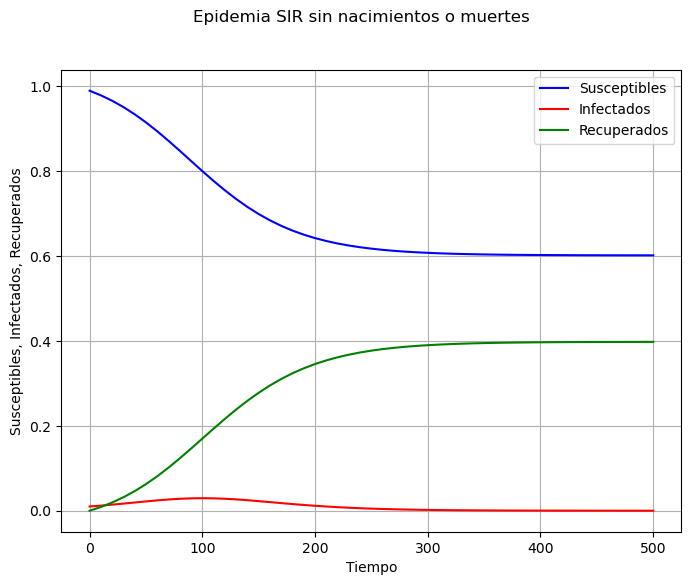

In [3]:
#@title MODELO SIR PARA EPIDEMIAS

import numpy as np
import time
import matplotlib.pyplot as plt

# Modelo SIR para epidemias

def SIR(t, statevector, params):
    """
    Sistema de Ecuaciones Diferenciales del Modelo SIR.

    Parámetros:
    - t: Tiempo actual (no se usa en esta función, pero es útil para integradores).
    - statevector: Vector de estado actual del sistema [S, I, R].
    - params: Parámetros del modelo [gamma, beta].

    Retorna:
    - Derivadas [dS/dt, dI/dt, dR/dt] en el tiempo actual.
    """
    gamma, beta = params
    s, i, r = statevector
    ds = - beta * s * i
    di = beta * s * i - gamma * i
    dr = gamma * i
    return np.array([ds, di, dr])

def RK4(func, initial_state, t0, tf, h, params):
    """
    Implementación del método de Runge-Kutta de cuarto orden para resolver ODEs.

    Parámetros:
    - func: Función que define las ecuaciones diferenciales (ODEs).
    - initial_state: Estado inicial del sistema [S0, I0, R0].
    - t0: Tiempo inicial.
    - tf: Tiempo final.
    - h: Paso de tiempo para la integración.
    - params: Parámetros del modelo [gamma, beta].

    Retorna:
    - sol: Solución numérica de las ODEs, incluyendo tiempos y estados [t, S, I, R].
    """
    times = np.arange(t0, tf + h, h)
    num_steps = len(times)
    states = np.zeros((num_steps, len(initial_state)))
    states[0] = initial_state
    for i in range(1, num_steps):
        k1 = h * func(times[i - 1], states[i - 1], params)
        k2 = h * func(times[i - 1] + 0.5 * h, states[i - 1] + 0.5 * k1, params)
        k3 = h * func(times[i - 1] + 0.5 * h, states[i - 1] + 0.5 * k2, params)
        k4 = h * func(times[i - 1] + h, states[i - 1] + k3, params)
        states[i] = states[i - 1] + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
    sol = np.transpose(np.concatenate((times.reshape(-1, 1), states), 1))
    return sol

def grafica(sol):
    """
    Genera y muestra un gráfico del resultado de la simulación SIR.

    Parámetros:
    - sol: Solución numérica de las ODEs [t, S, I, R].
    """
    t, s, i, r = sol[0], sol[1], sol[2], sol[3]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(t, s, "b-", label=r"Susceptibles")
    ax.plot(t, i, "r-", label=r"Infectados")
    ax.plot(t, r, "g-", label=r"Recuperados")
    ax.set_xlabel(r"Tiempo")
    ax.set_ylabel(r"Susceptibles, Infectados, Recuperados")
    ax.grid(True)
    ax.legend()
    fig.suptitle("Epidemia SIR sin nacimientos o muertes")


if __name__ == "__main__":

    #Parámetros
    beta = 0.1
    gamma = 0.08
    params = np.array([gamma, beta])

    #Condiciones Iniciales
    S0=0.99
    I0=0.01
    R0=0
    ci = np.array([S0, I0, R0])

    #Intervalo de tiempo
    t0 = 0
    tf = 500
    h = 1e1

    #Solución
    sol = RK4(SIR, ci, t0, tf, h, params)


    #Gráfica
    grafica(sol)






b) El archivo CoronavirusColombiayBogota.xmls contiene los datos de los casos reportados de
Covid-19 para Colombia y para Bogotá.


• Escoja un grupo de datos (Colombia o Bogotá) y utilice los datos del inicio de la pandemia
para deducir una rata de crecimiento diario 𝑎 = 𝑖(𝑡 + 1)/𝑖(𝑡) e identifique un día en el que
este valor ya esté estable. Identifique ese día como el momento inicial de la pandemia 𝑡 = 0.
Calcule los valores de iniciales como 𝑟 = 0, 𝑠 = 1 − 𝑖 e 𝑖 = 𝐼/𝑁, utilizando el número de
casos activos I en ese momento y una población de N=45,000,000 para Colombia o
N=8,000,000 para Bogotá.


In [4]:
#@title Carga y limpieza de datos

# Importación de librerías necesarias para el manejo de datos y la generación de gráficas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Cargar los datos desde un archivo Excel específico.
# Se especifica 'sheet_name' para indicar la hoja del archivo Excel que contiene los datos de interés.
data = pd.read_excel('Coronavirus Colombia y Bogota.xlsx', sheet_name='Bogotá')

# Limpiar los datos eliminando filas que contengan valores NaN (Not a Number) en las columnas 'dias' y 'Casos Activos'.
# Esto asegura que solo se trabajará con datos completos, lo cual es importante para análisis y visualizaciones precisas.
data_clean = data.dropna(subset=["dias", "Casos Activos"])

# Convertir los datos limpios a arreglos de NumPy para facilitar su manipulación y análisis.
# Se extraen dos columnas de interés: 'dias' y 'Casos Activos', las cuales representan el eje X y Y respectivamente para la visualización posterior.
dias, infectados = data_clean["dias"].to_numpy(), data_clean["Casos Activos"].to_numpy()




c:\Users\cterr\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


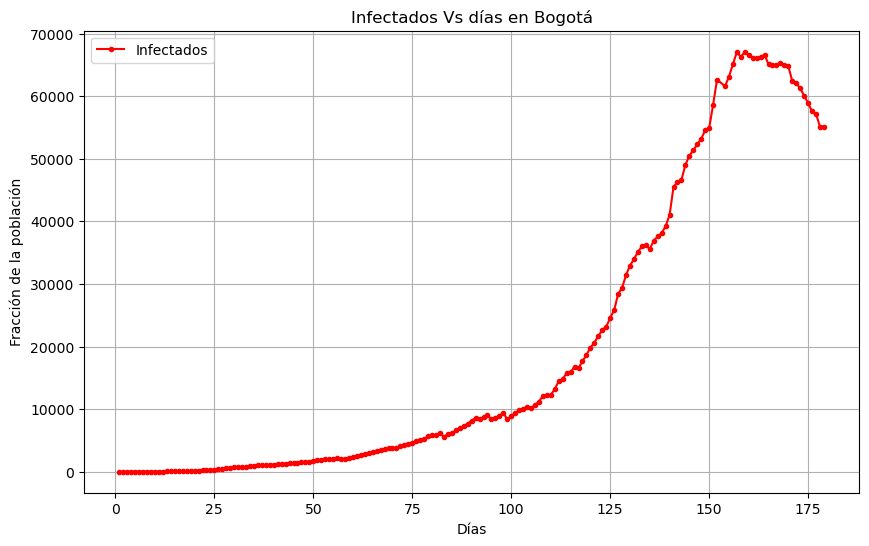

In [5]:
#@title Grafica de la evolución de los infectados

# Determinar el día con el pico más alto de infectados.
# Esto se logra encontrando el índice del máximo valor en el arreglo 'infectados', que luego puede usarse para identificar el día específico.
dia_pico_observado = infectados.argmax()

# Creación de una figura para la gráfica con dimensiones específicas.
plt.figure(figsize=(10, 6))

# Generación de la gráfica de línea para visualizar la evolución de los infectados a lo largo del tiempo.
# Se utiliza un formato de línea roja punteada y se etiqueta la serie de datos como "Infectados".
plt.plot(dias, infectados, "r.-", label=r"Infectados")

# Establecimiento del título de la gráfica y etiquetas para los ejes X e Y.
# Estas etiquetas ayudan a comprender qué representa cada eje.
plt.title('Infectados Vs días en Bogotá')
plt.xlabel('Días')
plt.ylabel('Fracción de la población')

# Adición de una leyenda a la gráfica para identificar las series de datos, y habilitación de la cuadrícula para facilitar la lectura de valores.
plt.legend()
plt.grid(True)

# Mostrar la gráfica generada.
plt.show()

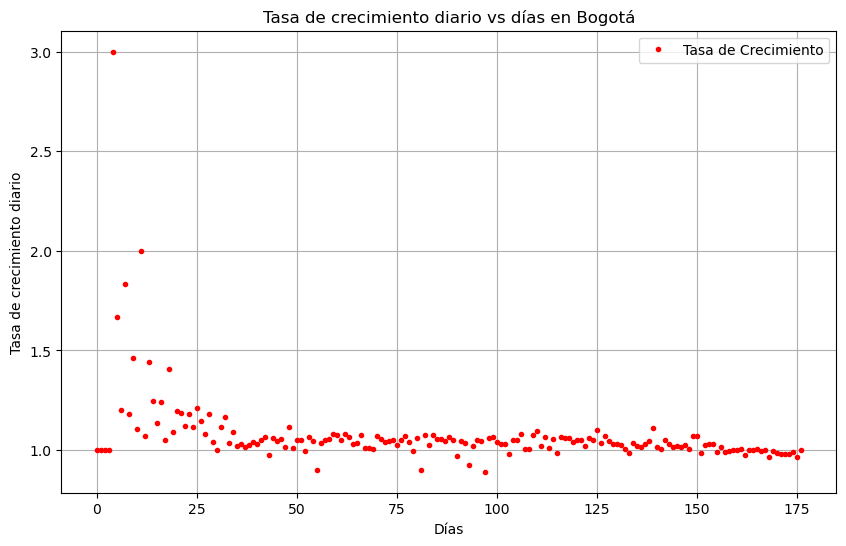

In [6]:

import numpy as np
import matplotlib.pyplot as plt

# Inicialización de un arreglo para almacenar la tasa de crecimiento diario de infectados.
# La longitud del arreglo es igual a la cantidad de días menos uno, ya que el cálculo de la tasa compara cada día con el siguiente.
a = np.zeros(len(infectados)-1)

# Cálculo de la tasa de crecimiento diario para cada día.
# Se divide el número de infectados de un día por el número de infectados del día anterior.
# Este bucle itera a través de todos los días disponibles excepto el último, ya que compara cada día con su sucesor.
for t in range(len(infectados)-1):
    a[t] = np.divide(infectados[t+1], infectados[t])

# Análisis del crecimiento diario para identificar el día con la menor tasa de crecimiento.
# Esto puede indicar cuando la propagación de la enfermedad comenzó a desacelerarse significativamente.

# Cálculo del promedio de las tasas de crecimiento a partir del día 100.
# Se asume que cualquier estabilización o tendencia a largo plazo se hará evidente después de los primeros 100 días.
a_estable = a[100:]
a_mean_estable = np.mean(a_estable)
a_std_etable = np.std(a_estable)

t_stable = np.where(a_estable < a_mean_estable - 2*a_std_etable)[0]

# Generación de una gráfica para visualizar la tasa de crecimiento diario de los infectados.
plt.figure(figsize=(10, 6))
plt.plot(a, "r.", label=r"Tasa de Crecimiento")

# Configuración de títulos y etiquetas para los ejes.
# Ayuda a identificar el contenido de la gráfica, facilitando la interpretación de los datos.
plt.title('Tasa de crecimiento diario vs días en Bogotá')
plt.xlabel('Días')
plt.ylabel('Tasa de crecimiento diario')

# Adición de una leyenda y activación de la cuadrícula para mejorar la legibilidad de la gráfica.
plt.legend()
plt.grid(True)

# Muestra la gráfica.
plt.show()

Basándonos en el gráfico anterior, podemos observar que la tendencia se estabiliza después del día 100. Por lo tanto, si dividimos los datos después de este punto y calculamos su media, podemos determinar el valor al que tiende la gráfica, lo cual nos proporciona el valor establecido de a. 

Para identificar el día en que esto ocurrió, calculamos la media más o menos 0.1 desviaciones estándar, donde aproximadamente el 8% de los datos estarán comprendidos.

In [359]:
from scipy.stats import norm

# Definir los límites en desviaciones estándar
limite_inferior = -0.25
limite_superior = 0.25

# Calcular la probabilidad acumulada en los límites
prob_limite_inferior = norm.cdf(limite_inferior)
prob_limite_superior = norm.cdf(limite_superior)

# Calcular el porcentaje de valores dentro de ±0.1 desviaciones estándar
porcentaje = (prob_limite_superior - prob_limite_inferior) * 100

print("El porcentaje de valores dentro de ±0.1 desviaciones estándar de la media es:", porcentaje, "%")


El porcentaje de valores dentro de ±0.1 desviaciones estándar de la media es: 19.74126513658474 %


In [387]:
a_estable = a[100:]
a_mean_estable = np.mean(a_estable)
a_std_etable = np.std(a_estable)

# Utiliza '&' para 'y' lógico y '|' para 'o' lógico. Corrige la condición para que tenga sentido.
# Se agregan paréntesis alrededor de cada condición para asegurar la correcta evaluación.
t_stable_data = np.where((a_estable < (a_mean_estable + 0.1*a_std_etable)) &
                    (a_estable > (a_mean_estable - 0.1*a_std_etable)))[0]
t_stable_data = t_stable_data + 100
t_stable_data

array([111, 131, 147, 152], dtype=int64)

Tomaremos el primer valor de t_stable como el día en que la tasa de crecimiento se estabiliza. Como
veremos a continuacion el valor de a para el dia escogido es bastante cercano a la media de a_estable

In [388]:
t_stable = t_stable_data[0] 
a[t_stable],a_mean_estable,a_std_etable

(1.0225215889464594, 1.0236919272784235, 0.03246593965732753)

Con el valor de t_estable calculamos las condiciones Iniciales

In [389]:
#Condiciones Iniciales
# Población de Bogota
N = 8e6

# Número de casos activos en el momento inicial (hipotético)
I_inicial = infectados[t_stable]
#I_inicial = infectados[100]


# Calcular S0, I0, y R0 basado en los datos hipotéticos
I0 = I_inicial / N
S0 = 1 - I0
R0 = 0.0  # Asumimos que inicialmente no hay recuperados


ci = np.array([S0, I0, R0])

print("Las condiciones iniciales son: R0 =",R0,".I0 =",I0,",S0 =",S0)

Las condiciones iniciales son: R0 = 0.0 .I0 = 0.001809375 ,S0 = 0.998190625


• Luego, considere el siguiente procedimiento, que se puede considerar como si fuera una
función 𝑓(𝛾): Dado un valor de 𝛾, calcule 𝛽 a partir de 𝑎. Con estos valores de 𝛽 y 𝛾, corra la
simulación del modelo SIR. Como resultado de la simulación, calcule el número de días
$𝑡_simulado$, en el que se presenta el pico en la simulación, y defina la función $𝑓(𝛾) = 𝑡_{simulado} − 𝑡_{datos}$, donde $t_{datos}$ es el día en el que ocurre el pico, contado desde el momento inicial.


Para resolver el problema anterior veamos como se comporta la ecuación que gobierna a los infectados
$$
\frac{d i}{d t}=\beta s i-\gamma i
$$
En el momento inicial de la pandemia tenemos que , $s(t) \sim s(0)=$ cte. Luego,
$$
\frac{d i}{d t}=(\beta s(0)-\gamma) i
$$
, cuya solución es una exponencial creciente si $\frac{\beta s(0)}{\gamma}>1$. Asi pues
$$
\begin{aligned}  
i(t)=i(0) e^{(\beta-\gamma) t} \\
a=\frac{i(t+1)}{i(t)}=&\frac{i(0) e^{(\beta-\gamma)(t+1)}}{i(0) e^{(\beta-\gamma) t}}=e^{(\beta-\gamma)} \\
\quad \beta-\gamma&=\ln (a)\\
\beta =& \gamma + \ln (a)
\end{aligned}
$$
Tomando el gamma como $\gamma$ = 0.08. Realizamos la simulación para ver como se comporta el sistema con estos parametros y las condiciones inciales calculadas en el numeral anterior

Dia pico simulado:  182.10000000000002


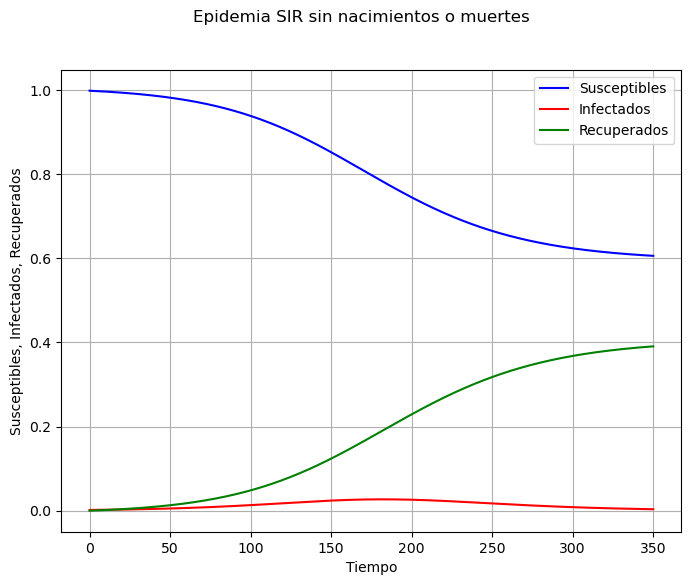

In [403]:
# Parámetros
gamma = 0.08
beta = gamma + np.log(a[t_stable])
params = np.array([gamma, beta])

#Intervalo de tiempo
t0 = 0
tf = 350
h = 1e-1

#Solución
sol = RK4(SIR, ci, t0, tf, h, params)

#Gráfica
grafica(sol)

#Maximo de infectados
infectados_simulados = sol[2]
dia_pico_simulado = np.argmax(infectados_simulados)*h
print("Dia pico simulado: ", dia_pico_simulado)



Ahora definimos una funcion que nos devuelva el día del pico de infectados y con esta definimos la funcion f_gamma como:
$$f(\gamma)=t_{simulado}-t_{datos}$$
Ademas graficamos esta funcion para ver como se comporta

In [404]:
# # Se definen los parámetros iniciales para la simulación del modelo SIR.
# t0 = 0  # Tiempo inicial de la simulación.
# tf = 350  # Tiempo final de la simulación.
# h = 1e0  # Paso de tiempo para la simulación (1 día en este caso).


# Función para simular el modelo SIR y encontrar el día del pico de infectados.
def dia_pico(gamma):
    """
    Simula el modelo SIR dado un valor de beta y encuentra el día del pico de infectados.

    Parámetros:
    - beta: Tasa de transmisión de la enfermedad.

    Retorna:
    - dia_pico: Día en el cual se alcanza el máximo número de infectados.
    """
    # Cálculo del parámetro beta basado en gamma y el crecimiento estable de infectados.
    beta = gamma + np.log(a[t_stable])
    # Se realiza la simulación del modelo SIR con los parámetros dados.
    infectados = RK4(SIR, ci, t0, tf, h, (gamma, beta))[2]
    # Se encuentra el índice del máximo número de infectados y se multiplica por el paso de tiempo para obtener el día correspondiente.
    dia_pico = np.argmax(infectados) * h  
    return dia_pico

# Vectorización de la función dia_pico para permitir su uso con arrays de NumPy.
dia_pico = np.vectorize(dia_pico)

# Función para calcular la diferencia absoluta entre el día del pico observado y el simulado.
def f_gamma(gamma):
    """
    Calcula la diferencia absoluta entre el día del pico de infectados observado y el simulado para un valor de beta.

    Parámetros:
    - beta: Tasa de transmisión de la enfermedad.

    Retorna:
    - Diferencia absoluta entre el día del pico observado y el simulado.
    """
    # return np.abs(dia_pico(gamma) - dia_pico_observado)
    return dia_pico(gamma) - dia_pico_observado

# Vectorización de la función f_gamma para permitir su uso con arrays de NumPy.
f_gamma = np.vectorize(f_gamma)

# Creación de un array de valores de beta para evaluar la función f_gamma.
gamma_data = np.linspace(0, 1, 1000)  # Array de 1000 puntos entre 0 y 1.
# Evaluación de la función f_gamma para cada valor de beta en beta_data.
f_gamma_data = f_gamma(gamma_data)


Text(0.5, 1.0, 'Diferencia del tiempo maximo vs beta')

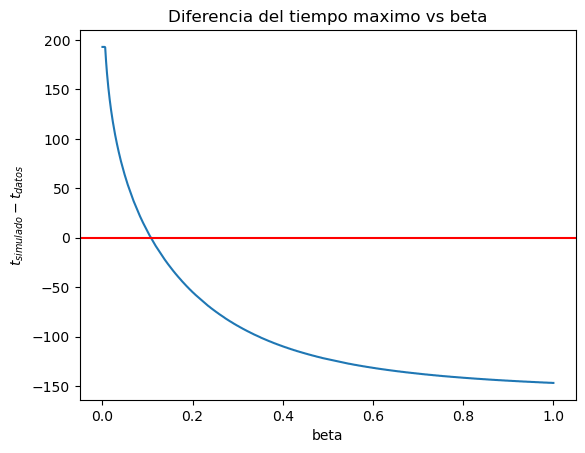

In [405]:
plt.plot(gamma_data,f_gamma_data,"-")
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('beta')
plt.ylabel(r'$t_{simulado} - t_{datos}$')
plt.title('Diferencia del tiempo maximo vs beta')

• Finalmente, utilice el método de la bisección de esta “función” para identificar el valor de
𝛾 que predice correctamente el momento de aparición del pico (𝑓(𝛾) = 0).

In [410]:
def biseccion(f, a, b, ERR):
    """
    Encuentra una raíz de la función f en el intervalo [a, b] usando el método de bisección.

    Parámetros:
    - f: La función para la cual se busca encontrar una raíz.
    - a, b: Los extremos del intervalo inicial [a, b] dentro del cual buscar la raíz.
    - ERR: El criterio de parada basado en la precisión deseada del resultado.

    Retorna:
    - El punto medio del intervalo final como la aproximación de la raíz.
    """
    fa = f(a)
    fb = f(b)

    if fa * fb > 0:
        raise ValueError("La función debe cambiar de signo en el intervalo.")
    if fa == 0:
        return a
    if fb == 0:
        return b

    while b - a > ERR:
        m = (a + b) / 2
        fm = f(m)
        if fm == 0 or (b - a) / 2 < ERR:
            return m
        if fa * fm < 0:
            b = m
            fb = fm
        else:
            a = m
            fa = fm
    return (a + b) / 2
    # fa = f(a)  # Calcula el valor de la función en el extremo inferior del intervalo
    # while b - a > ERR:  # Continúa la iteración hasta que el intervalo sea menor que el error tolerado
    #     m = (a + b) / 2  # Encuentra el punto medio del intervalo
    #     fm = f(m)  # Calcula el valor de la función en el punto medio
    #     if fa * fm > 0:  # Si f(a) y f(m) tienen el mismo signo, la raíz está en [m, b]
    #         a = m
    #         fa = fm
    #     else:  # Si no, la raíz está en [a, m]
    #         b = m
    # return (a + b) / 2  # Retorna el punto medio del intervalo final



# Define los límites iniciales del intervalo para la búsqueda de beta
gamma_min = 0.0
gamma_max = 1

# Utiliza el método de bisección para encontrar el valor de beta que minimiza la diferencia entre
# el día pico simulado y el observado, dentro de un error de tolerancia de 1e-6.
gamma_optimo = biseccion(f_gamma, gamma_min, gamma_max, 1e-3)

# Imprime el valor óptimo de beta encontrado y la diferencia asociada con este valor.
print(f"""El valor de gamma que minimiza la diferencia entre el día del pico simulado y 
      el observado y que por tanto predic de manera correcta el momento de la aparición del 
      pico de la enfermedad es:   {gamma_optimo:.4f}""")


El valor de gamma que minimiza la diferencia entre el día del pico simulado y 
      el observado y que por tanto predic de manera correcta el momento de la aparición del 
      pico de la enfermedad es:   0.1074


Text(0.5, 1.0, 'Diferencia del tiempo maximo vs beta')

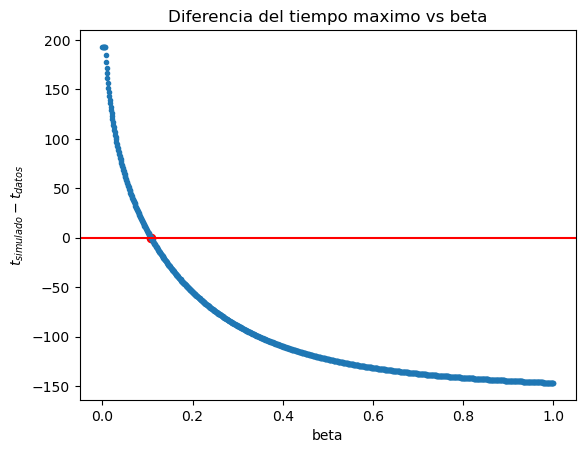

In [411]:
plt.plot(gamma_data,f_gamma_data,".")
plt.scatter(gamma_optimo,f_gamma(gamma_optimo),color= 'r')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('beta')
plt.ylabel(r'$t_{simulado} - t_{datos}$')
plt.title('Diferencia del tiempo maximo vs beta')

Por ultimo corremos la simulación con el gamma optimo

Día pico simulado: 157.0, Día pico observado: 157


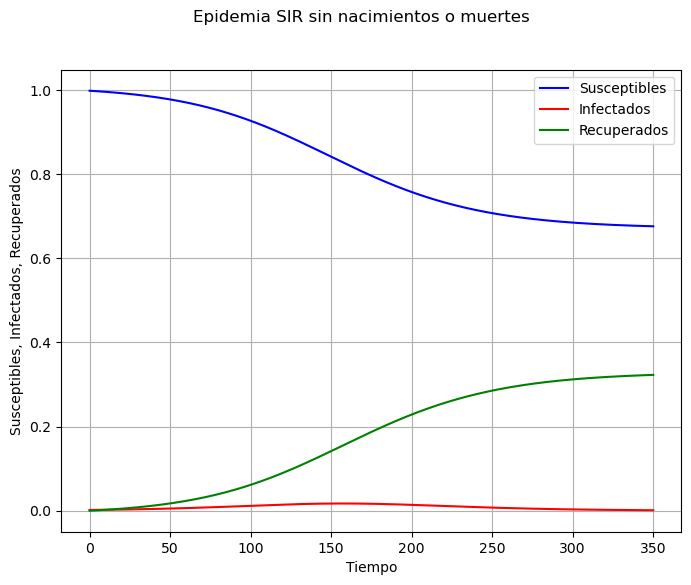

In [412]:
# Parámetros
gamma = gamma_optimo
beta = gamma + np.log(a[t_stable])
params = np.array([gamma, beta])

#Intervalo de tiempo
t0 = 0
tf = 350
h = 1e-1

#Solución
sol = RK4(SIR, ci, t0, tf, h, params)

#Gráfica
grafica(sol)

#Maximo de infectados
infectados_simulados = sol[2]
dia_pico_simulado = np.argmax(infectados_simulados)*h
print(f"Día pico simulado: {dia_pico_simulado}, Día pico observado: {dia_pico_observado}")

